In [17]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
import cv2 #biblioteca de prelucrare de imagini
from tensorflow.keras import layers
from keras.layers import Dense, Flatten, Dropout, BatchNormalization, Activation, Add, MaxPooling2D, Conv2D
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.utils import resample

from tensorflow import keras

In [18]:
os.environ['TF_DISABLE_MEMORY_OPTIMIZATION']='1'

In [19]:
def load_breakhis_400x_data(train_dir, test_dir):
    label_to_index = {'benign': 0, 'malignant': 1}

    def load_images_from_directory(directory):
        images = []
        labels = []
        for label_name in os.listdir(directory): #parcurg fiecare fisier din directorul meu
            label_index = label_to_index[label_name] #atribui 0 pentru benign si 1 pentru malignant
            label_dir = os.path.join(directory, label_name) #fac un path catre fisierul meu cu poze pentru al accesa
            for image_file in os.listdir(label_dir):  #parcurg fiecare imagine
                image_path = os.path.join(label_dir, image_file)  #creez path-ul catre imagine
                image = cv2.imread(image_path) 
                image = cv2.resize(image, (128, 128))  #in caz ca nu au toate aceeasi dimensiune le redimensionez la dimensiunea 128x128
                images.append(image) #adaug imaginea in lista
                labels.append(label_index) #adaug indexii in lista
        return np.array(images), np.array(labels)  #returnez o matrice pentru fiecare
    
    x_train, y_train = load_images_from_directory(train_dir) #train: poze pentru antrenare
    x_test, y_test = load_images_from_directory(test_dir) #test: poze noi, le vede prima data
    #normalizare; 
    x_train = x_train/255.0 #x_train și x_test sunt împărțite la 255.0. 
    #Aceasta transformare se face pentru a scala valorile pixelilor din intervalul [0, 255] în intervalul [0, 1].
    x_test = x_test/255.0
    return x_train, y_train, x_test, y_test

In [20]:
train_directory = "/kaggle/input/breakhis-400x/BreaKHis 400X/train"
test_directory = "/kaggle/input/breakhis-400x/BreaKHis 400X/test"

In [21]:
x_train, y_train, x_test, y_test = load_breakhis_400x_data(train_directory, test_directory)

In [22]:
permutation = np.random.permutation(len(x_train))

In [23]:
x_train_shuffled = x_train[permutation]
y_train_shuffled = y_train[permutation]

In [25]:
# Calculculeaza ponderi pentru fiecare clasa; dataset-ul meu e imbalansat
total = len(y_train)
pos = np.sum(y_train == 1)
neg = np.sum(y_train == 0)

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))


Weight for class 0: 1.55
Weight for class 1: 0.74


In [46]:
model = Sequential([ #sequential: grupez fiecare strat intru-un model
    
    Flatten(input_shape=(128, 128, 3)), #flatten: face imaginea ca fiind vector; 3-imaginea RGB
    Dense(1024, activation='relu'),    #primul strat de neuroni cu 1024 neuroni
    BatchNormalization(),             #normalizeaza datele intre 0 si 1
    Dropout(0.3),                     #renunt la 0.3 din informatie
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(8, activation='gelu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(4, activation='softmax'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(2, activation='softmax')  #strat de iesire cu cele 2 clase; returnez o singura valoare
    
]) 

In [47]:
optimizer = Adam(learning_rate=0.001) #optimizez loss-ul; caut minimul acestei functii de loss; Adam-gradient descendent; learning rate-pas de invatare

In [48]:
model.compile(optimizer=optimizer, 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy']) 

In [49]:
model.fit(x_train, y_train, epochs=15,  
          batch_size=15, class_weight=class_weight) 
#antrenam modelul, pentru fiecare dintre cele 15 epoci(pasi) iau cate 15 imagini deodata
#acuratete: cat de bine le clasific; loss: cat pierd din informatie; vrem ca acuratetea sa fie cat mai mare si lossul cat mai mic
#Acuratețea reprezintă proporția de predicții corecte față de totalul predicțiilor.
#Funcția de pierdere (loss) măsoară cât de bine modelează modelul relația dintre variabilele de intrare și cele de ieșire

Epoch 1/15
10/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4241 - loss: 1.0070

W0000 00:00:1716323000.559465     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


77/77 ━━━━━━━━━━━━━━━━━━━━ 43s 265ms/step - accuracy: 0.5031 - loss: 0.9025
Epoch 2/15
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5023 - loss: 0.8768

W0000 00:00:1716323020.669423     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5662 - loss: 0.7580
Epoch 3/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6017 - loss: 0.6678
Epoch 4/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5916 - loss: 0.6803
Epoch 5/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6207 - loss: 0.6468
Epoch 6/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6696 - loss: 0.6092
Epoch 7/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6462 - loss: 0.6213
Epoch 8/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6566 - loss: 0.6212
Epoch 9/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6549 - loss: 0.6230
Epoch 10/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7277 - loss: 0.5619
Epoch 11/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7357 - loss: 0.5707
Epoch 12/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7286 - loss: 0.5602
Epoch 13/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7785 - 

In [50]:
results = model.evaluate(x_test,  y_test, verbose = 0) 
print('test loss, test acc:', results) #dupa invatare i-am dat modelului pozele de test pe care nu le-a mai vazut

W0000 00:00:1716323043.523631     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


test loss, test acc: [0.47749483585357666, 0.8110091686248779]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


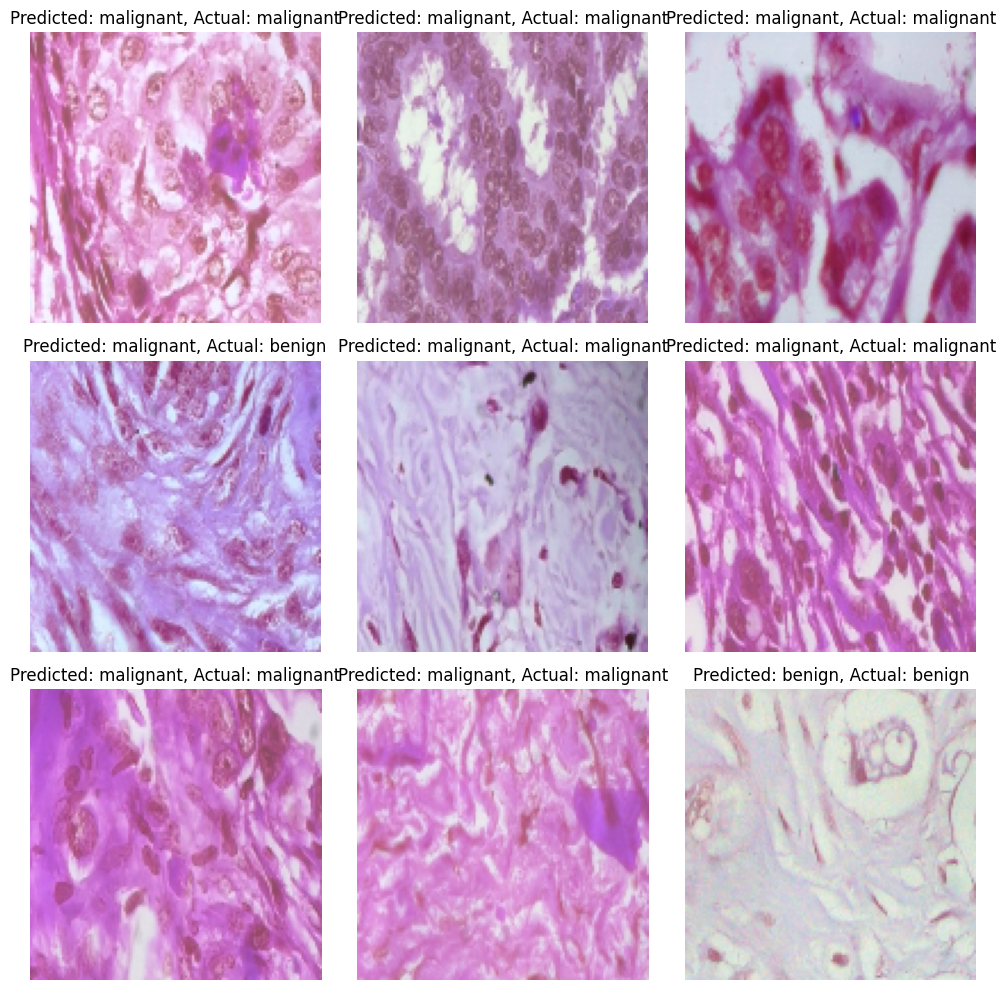

In [51]:
#vizualiez predictia pe 9 imagini random
class_names = ['benign', 'malignant']
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.flatten()

for i in range(9):
    index = np.random.randint(0, len(x_test))
    axes[i].imshow(x_test[index])
    prediction = model.predict(x_test[index:index+1])
    predicted_class = np.argmax(prediction)
    axes[i].set_title("Predicted: {}, Actual: {}".format(class_names[predicted_class], class_names[y_test[index]]))
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [52]:
from sklearn.metrics import classification_report #generez un raport detaliat al performanței clasificatorului
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1']))
#Precizia: Proporția de instanțe prezise ca fiind pozitive care sunt cu adevărat pozitive.
#Recall-ul: Proporția de instanțe pozitive reale care sunt corect identificate.
#F1-Score-ul: Media armonică a preciziei și recall-ului, oferind o măsură echilibrată.
#Suportul: Numărul de instanțe reale pentru fiecare clasă din setul de date de testare.

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 
              precision    recall  f1-score   support

     Class 0       0.72      0.68      0.70       176
     Class 1       0.85      0.88      0.86       369

    accuracy                           0.81       545
   macro avg       0.79      0.78      0.78       545
weighted avg       0.81      0.81      0.81       545



W0000 00:00:1716323080.169401     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
